In [44]:
import pandas as pd
import numpy as np

!pip3 install surprise
from surprise import Reader
from surprise import Dataset
from surprise import SVD               # importer ici les algo qu'on testera
from surprise import model_selection

from sklearn.model_selection import train_test_split 

In [45]:
df = pd.read_csv("Datasets/data_train.csv")

df[["user", "item"]] = df.Id.str.split("_", expand=True)

df.user = df.user.str.replace("r", "")
df.item = df.item.str.replace("c", "")

#########
df2 = pd.read_csv("Datasets/sample_submission.csv")

df2[["user", "item"]] = df2.Id.str.split("_", expand=True)

df2.user = df2.user.str.replace("r", "")
df2.item = df2.item.str.replace("c", "")

df

,Id,Prediction,user,item
0,r44_c1,4,44,1
1,r61_c1,3,61,1
2,r67_c1,4,67,1
3,r72_c1,3,72,1
4,r86_c1,5,86,1
...,...,...,...,...
1176947,r9990_c1000,4,9990,1000
1176948,r9992_c1000,5,9992,1000
1176949,r9994_c1000,3,9994,1000
1176950,r9997_c1000,4,9997,1000


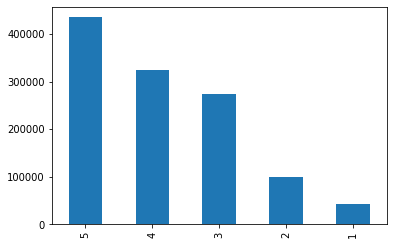

In [46]:
df.Prediction.value_counts().plot.bar()

In [47]:
df_fifth, test = train_test_split(df, test_size=0.9, random_state=1)

In [49]:
reader = Reader(rating_scale=(1,5)) 
data = Dataset.load_from_df(df[["user","item","Prediction"]], reader)
data_fifth = Dataset.load_from_df(df_fifth[["user","item","Prediction"]], reader)


In [51]:
del df#freeing memory
del df_fifth

NameError: name 'df' is not defined

Principe de SKLearn et Surprise qui est basé sur le premier:
* définition d'un test model à travers model_selection.gridsearchcv
* testmodel.fit qui va tester les model et paramètres pour retourner ce qu'il y a de mieux
* algorithm = testmodel.best_estimator["type de erreur choisi"] nous donne le meilleur algo selon les meilleur paramtère
* algo.fit(data)
* algo.estimate(data a tester)

Dans la cell suivante, on va créer un "model selection" qui se base sur grid search cv. Ce dernier prend des paramètres et pourrait prendre plusieurs algos, a tester chacun selon les paramètres etc etc, mais ce n'est qu'une définition de model selection

Parameters pour SVD, pas forcément tous mais principalement :
* n_factors – The number of factors. Default is 100.
* n_epochs – The number of iteration of the SGD procedure. Default is 20.
* biased (bool) – Whether to use baselines (or biases). See note above. Default is True.
* init_mean – The mean of the normal distribution for factor vectors initialization. Default is 0.
* init_std_dev – The standard deviation of the normal distribution for factor vectors initialization. Default is 0.1.
* lr_all – The learning rate for all parameters. Default is 0.005.
* reg_all – The regularization term for all parameters. Default is 0.02.
* lr_bu – The learning rate for bu. Takes precedence over lr_all if set. Default is None.
* lr_bi – The learning rate for bi. Takes precedence over lr_all if set. Default is None.
* lr_pu – The learning rate for pu. Takes precedence over lr_all if set. Default is None.
* lr_qi – The learning rate for qi. Takes precedence over lr_all if set. Default is None.
* reg_bu – The regularization term for bu. Takes precedence over reg_all if set. Default is None.
* reg_bi – The regularization term for bi. Takes precedence over reg_all if set. Default is None.3
* reg_pu – The regularization term for pu. Takes precedence over reg_all if set. Default is None.
* reg_qi – The regularization term for qi. Takes precedence over reg_all if set. Default is None.
* random_state (int, RandomState instance from numpy, or None) – Determines the RNG that will be used for initialization. If int, random_state will be used as a seed for a new RNG. This is useful to get the same initialization over multiple calls to fit(). If RandomState instance, this same instance is used as RNG. If None, the current RNG from numpy is used. Default is None.
* verbose – If True, prints the current epoch. Default is False.m

In [18]:
param_grid = {
    'n_epochs': [500],
    'lr_all': [0.001, 0.003, 0.005],
    'reg_all': [0.065, 0.07, 0.075]
} 
cv=5
algorithm = SVD


#définition du model selon les paramètres, attention a importer dans la première cell les autres algos

#  https://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.search.GridSearchCV

gs = model_selection.GridSearchCV(algorithm, param_grid, measures=['rmse'], cv=cv, n_jobs=-5, joblib_verbose=100)  #enlever mae car non utilisé dans le projet pour sauver du temps


In [20]:
tasks = 1
for i in param_grid:
    tasks *= len(param_grid.get(i))

tasks *= cv
print("Total number of tasks to compute : ",tasks)

Total number of tasks to compute :  30


In [ ]:
gs.fit(data) # les calculs se font actuellement ici 

In [ ]:
tmp = pd.DataFrame(gs.cv_results)
tmp

In [ ]:
tmp = tmp.drop(columns=["rank_test_rmse", "mean_fit_time", "mean_test_time" ,"std_fit_time", "std_test_time", "param_n_epochs", "param_lr_all","param_reg_all"])

In [ ]:
tmp.plot.bar(figsize=(12,8), ylim=(0.98, 1.02))

In [ ]:
print(gs.best_params)
print(gs.best_score)

In [ ]:
algo = gs.best_estimator["rmse"] #choix de l'algo selon l'erreur, touuuut inclus

In [ ]:
algo.fit(data.build_full_trainset()) # ici on va train notre algo sur le dataset complet, sans cv car les paramètres sont optimaux

La différence entre algo.predict et algo.estimate est que predict devrait être utilisé sur des valeurs que l'on connait d'avance, par exemple si on sait que le user 5 pour le film 12 a voté 3, on peut rentrer ces valeurs et voir "l'erreur"
algo.estimate fait littéralement ce qu'on veut pour le projet, c'est à dire estimer. Pas à 100% sur sur de ça ici mais c'est ce qui me parait le plus juste. Pour l'instant on boucle sur algo.estimate mais il y a peut etre mieux à faire 
il faudra round la valeur la remettre dans le pred.csv etc

In [ ]:
array = np.ones((df2.shape[0],1))
change_five=0
change_zero=0

for i in df2.iterrows():
    tmp = algo.estimate(int(i[1][2]), int(i[1][3]))
    tmp = round(tmp)
    if int(tmp)>5:
      tmp=5;
      change_fiveve +=1
    if int(tmp)<1:
      tmp=1;
      change_zero +=1
    array[i[0]]= (int(tmp))
    if i[0]%10000==0:
        print(i[0])
        
print("Changement de zero : ", change_zero)
print("Changement de cinq : ", change_five)

In [ ]:
array

In [ ]:
df2.Prediction = array

In [ ]:
#df2[df2.Prediction==5] uncomment to see the shape of how many of x value there are

In [ ]:
df2 = df2.drop(columns=["user", "item"])

In [ ]:
df2.to_csv("Datasets/submission.csv", index=False)